In [1]:
machine = "local"
!wandb login

wandb: Currently logged in as: dmykhailov (dmykhailov-kyiv-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Imports


In [2]:
import os
import gc
import glob
import logging
import numpy as np
import pandas as pd
from PIL import Image
from typing import cast
from matplotlib import pyplot as plt

import torch
import timm
import torch.nn as nn
import pytorch_lightning as pl
from tqdm import tqdm
from torchvision import transforms
from timm.data.config import resolve_data_config

import warnings
from notebooks_config import setup_logging, CustomLogger
from src.BiomassDataset import BiomassDataset
from src.BiomassImprovedCNN import BiomassImprovedCNN
from src.BiomassTransformer import BiomassTransformer
from src.image_transforms import get_transforms
from src.cv import create_folds_with_date_groups
from src.dataloaders import get_fold_loaders, print_fold_loader_info
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")
print(
    f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Available variables: ['BASE_DIR', 'DATA_DIR', 'Path', 'directory', 'find_project_root', 'project_root', 'sys']
PyTorch: 2.9.1+cu128
Device: NVIDIA GeForce RTX 5050 Laptop GPU


In [3]:
# Fix for deterministic CUDA operations
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [4]:
logger = setup_logging(
    level=logging.DEBUG,
    full_color=True,
    include_function=False
)
logger = cast(CustomLogger, logger)
logger.success("Logging configuration test completed.")


[2025-12-19 21:11:00]
SUCCESS: Logging configured successfully ✅

[2025-12-19 21:11:00]
SUCCESS: Logging configuration test completed.


## Configuration


In [5]:
cpu_count = os.cpu_count()
NUM_WORKERS = 0

# Training hyperparameters
LR = 1e-4
EPOCHS = 15
N_FOLDS = 5
GRAD_ACCUM = 4
BATCH_SIZE = 4
DROPOUT_RATE = 0.2
WEIGHT_DECAY = 0.05
HIDDEN_RATIO = 0.5

# Architecture options
USE_SPATIAL_ATTENTION = True
USE_CROSS_ATTENTION = True
FUSION_METHOD = 'gated'  # 'concat', 'gated', 'separate'
SCHEDULER = 'cosine'  # 'cosine', 'plateau'

# Targets
ALL_TARGETS = ['Dry_Clover_g', 'Dry_Dead_g',
               'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
USED_TARGETS = ['Dry_Green_g', 'Dry_Total_g', 'GDM_g']

# Model selection
# Good CNNs for this task:
# - 'tf_efficientnetv2_s.in21k_ft_in1k' (fast, good)
# - 'convnext_base.fb_in22k_ft_in1k' (slower, better) IMBA, SOTA
#
# Swin Transformer
# - 'swin_base_patch4_window7_224.ms_in22k_ft_in1k'
# - 'swin_large_patch4_window7_224.ms_in22k_ft_in1k'
# - 'swinv2_base_window8_256'  # Swin v2 (better)

# DINOv2 (Facebook's self-supervised)
# - 'vit_base_patch14_dinov2.lvd142m'  # Base
# - 'vit_large_patch14_dinov2.lvd142m'  # Large
# - 'vit_giant_patch14_dinov2.lvd142m'  # Giant (best quality, slow)

MODEL = 'vit_giant_patch14_dinov2.lvd142m'
ModelClass = BiomassImprovedCNN if not 'patch' in MODEL else BiomassTransformer

PROJECT_NAME = "csiro-image2biomass-prediction"
CHECKPOINTS_DIR = "./kaggle/checkpoints/improved_cnn/"

USE_LOG_TARGET = True

DESCRIPTION = (
    f"{machine}_"
    f"{MODEL.split('.')[0]}_"
    f"train[{N_FOLDS}]Folds_"
    f"{'log_' if USE_LOG_TARGET else ''}"
    f"fusion-{FUSION_METHOD}_"
    f"{'spatial_' if USE_SPATIAL_ATTENTION else ''}"
    f"{'cross_' if USE_CROSS_ATTENTION else ''}"
    f"epochs{EPOCHS}_bs{BATCH_SIZE}_gradacc{GRAD_ACCUM}_"
    f"lr{LR}_wd{WEIGHT_DECAY}_dr{DROPOUT_RATE}_hr{HIDDEN_RATIO}"
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

print("DESCRIPTION:", DESCRIPTION)
print(f"Effective batch size: {BATCH_SIZE * GRAD_ACCUM}")

Seed set to 42


DESCRIPTION: local_vit_giant_patch14_dinov2_train[5]Folds_log_fusion-gated_spatial_cross_epochs15_bs4_gradacc4_lr0.0001_wd0.05_dr0.2_hr0.5
Effective batch size: 16


In [6]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
print('NUM_WORKERS:', NUM_WORKERS)
print()

if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
    torch.set_float32_matmul_precision('high') if machine == "local" else None

    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda
NUM_WORKERS: 0

NVIDIA GeForce RTX 5050 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


## Data Loading


In [7]:
PATH_DATA = './kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TEST_CSV = os.path.join(PATH_DATA, 'test.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')
PATH_TEST_IMG = os.path.join(PATH_DATA, 'test')

df = pd.read_csv(PATH_TRAIN_CSV)
df = df[df['target_name'].isin(USED_TARGETS)].reset_index(drop=True)
print(f"Dataset size: {df.shape}")
display(df.head())

# Pivot to get one row per image
df_pivoted = df.pivot_table(
    index=['image_path', 'Sampling_Date', 'State', 'Species'],
    columns='target_name',
    values='target'
).reset_index()

print(f"\nPivoted dataset: {df_pivoted.shape}")
display(df_pivoted.head())

Dataset size: (1071, 9)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2750
1,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
2,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
3,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
4,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000



Pivoted dataset: (357, 7)


target_name,image_path,Sampling_Date,State,Species,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,16.2750,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,10.5261,34.1844,10.9605


## Model Configuration


In [8]:
# Create dummy model to get correct config
dummy_model = timm.create_model(MODEL, pretrained=False)
config = dummy_model.default_cfg

# Get height (all dims are same for square images)
input_size = int(config['input_size'][1])
mean = config['mean']
std = config['std']

print("Model config:")
print(f"  Input size: {config['input_size']}")
print(f"  Mean: {mean}")
print(f"  Std: {std}")

# Delete dummy model to free memory
del dummy_model

Model config:
  Input size: (3, 518, 518)
  Mean: (0.485, 0.456, 0.406)
  Std: (0.229, 0.224, 0.225)


In [9]:
train_transforms, valid_transforms = get_transforms(input_size, mean, std)

## Visualize Augmentations


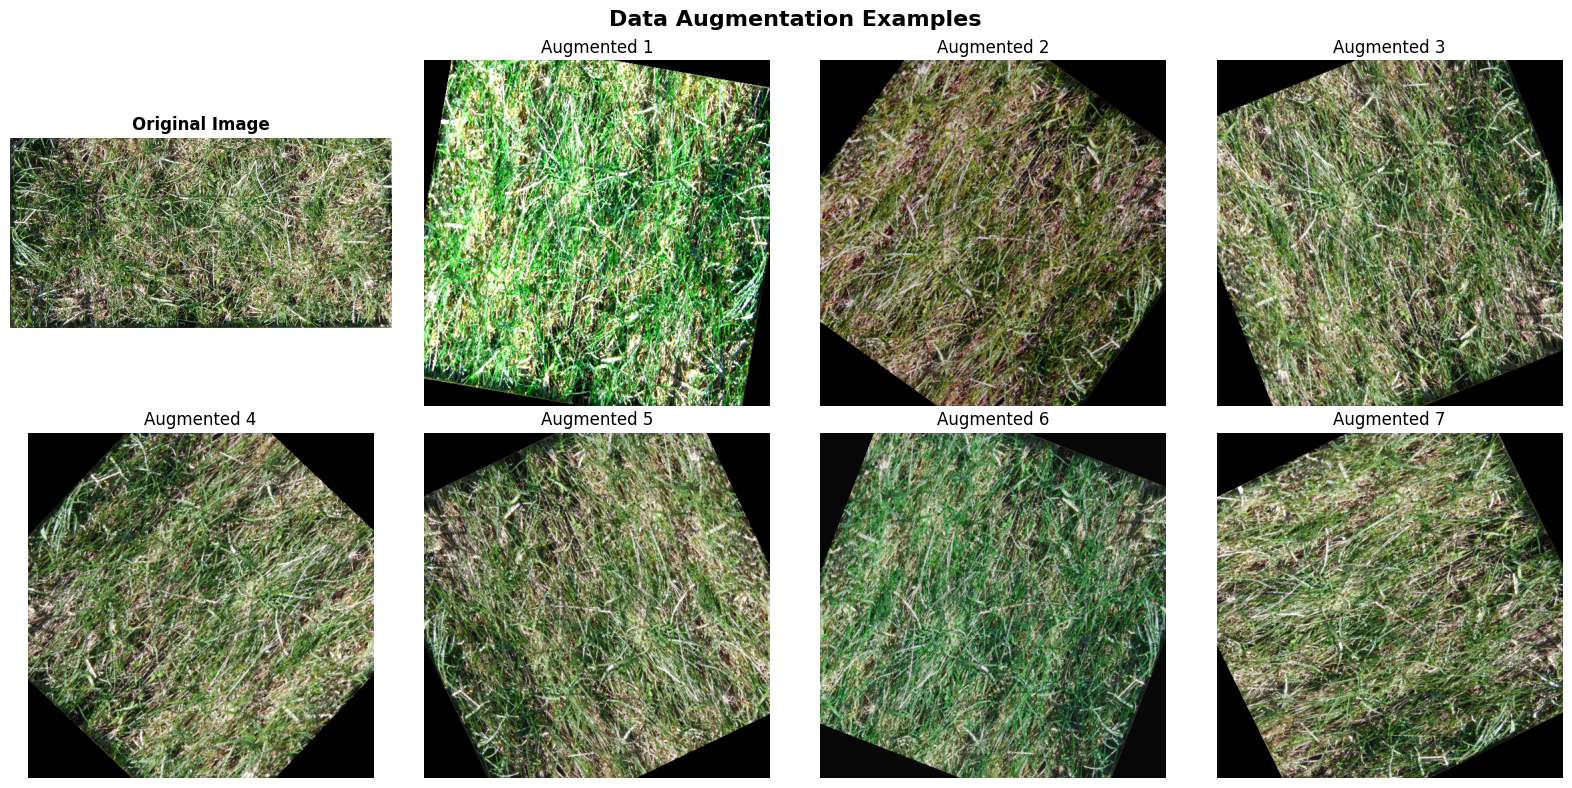

In [10]:
# Get sample image
sample_idx = 0
original_img_path = PATH_DATA + "/" + \
    str(df_pivoted.loc[sample_idx, 'image_path'])
original_img = Image.open(original_img_path).convert('RGB')

# Show augmentations
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

axes[0].imshow(original_img)
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

for i in range(1, 8):
    augmented = train_transforms(original_img)
    if not isinstance(augmented, torch.Tensor):
        augmented = transforms.ToTensor()(augmented)

    augmented = augmented.to(DEVICE)
    mean_temp = torch.tensor(mean).view(3, 1, 1).to(DEVICE)
    std_temp = torch.tensor(std).view(3, 1, 1).to(DEVICE)
    img_denorm = augmented * std_temp + mean_temp
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_np = img_denorm.cpu().permute(1, 2, 0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(f'Augmented {i}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Create Folds


In [11]:
df_with_folds = create_folds_with_date_groups(
    df_pivoted,
    n_folds=N_FOLDS,
    use_mass_stratification=True,
    n_mass_bins=5,
    mass_col='Dry_Total_g',
    random_state=SEED
)

print("\nFold distribution:")
print(df_with_folds['fold'].value_counts().sort_index())


Fold 0:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 1:
  Train samples: 282
  Val samples: 75
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 2:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 3:
  Train samples: 297
  Val samples: 60
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 4:
  Train samples: 279
  Val samples: 78
  ✓ No date overlap (train: 22 dates, val: 6 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 72
  State distribution:
    Tas: 52.8%
    Vic: 34.7%
    NSW: 12.5%
  Species distribution:
    Ryegrass_Clover: 37.5%
    Clover: 15.3%
    Ryegrass: 13.9%
    Fescue: 12.5%
    Phalaris_Ryegrass_Clover: 9.7%
    Phalaris_Clover: 8.3%
    Mixed: 2.8%
  Season distribution:
    Winter: 59.7%
    Spring: 27.8%
    Summer: 12.5%
  Mass bin distribution:
    mass_bin_0: 25.0%
    mass_bin_1: 22.2%
    mass_bin_2: 19.4%
    mass_bin_3: 16.7%
    mass_b

## Competition Metric


In [12]:
labels = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

weights = {
    'Dry_Clover_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Green_g': 0.1,
    'Dry_Total_g': 0.5,
    'GDM_g': 0.2,
}


def competition_metric(y_true, y_pred) -> float:
    """Calculate competition's weighted R2 score."""
    weights_array = np.array([weights[l] for l in labels])

    y_weighted_mean = np.average(y_true, weights=weights_array, axis=1).mean()

    ss_res = np.average((y_true - y_pred)**2,
                        weights=weights_array, axis=1).mean()
    ss_tot = np.average((y_true - y_weighted_mean)**2,
                        weights=weights_array, axis=1).mean()

    return 1 - ss_res / ss_tot

## Test Model Architecture


In [13]:
# Create dataset
train_dataset = BiomassDataset(
    df=df_pivoted,
    target_cols=USED_TARGETS,
    img_dir=PATH_TRAIN_IMG,
    transform=train_transforms,
    is_test=False,
    use_log_target=USE_LOG_TARGET
)

print(f"Dataset length: {len(train_dataset)}")

# Test sample
sample = train_dataset[0]
print(f"Left image shape: {sample['left_image'].shape}")
print(f"Right image shape: {sample['right_image'].shape}")
print(f"Targets shape: {sample['targets'].shape}")
print(f"Target values: {sample['targets']}")

Dataset length: 357
Left image shape: torch.Size([3, 518, 518])
Right image shape: torch.Size([3, 518, 518])
Targets shape: torch.Size([3])
Target values: tensor([2.8493, 3.8974, 2.8493])


In [14]:
# Create model
model = ModelClass(
    kaggle_score=competition_metric,
    backbone_name=MODEL,
    backbone_input_size=input_size,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    hidden_ratio=HIDDEN_RATIO,
    dropout=DROPOUT_RATE,
    use_log_target=USE_LOG_TARGET,
    freeze_backbone=True,
    use_spatial_attention=USE_SPATIAL_ATTENTION,
    use_cross_attention=USE_CROSS_ATTENTION,
    fusion_method=FUSION_METHOD,
    scheduler=SCHEDULER
)
model.to(DEVICE)

print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)
print("\n" + "="*80)

# Test forward pass
with torch.no_grad():
    test_batch = {
        'left_image': sample['left_image'].unsqueeze(0).to(DEVICE),
        'right_image': sample['right_image'].unsqueeze(0).to(DEVICE),
        'targets': sample['targets'].unsqueeze(0).to(DEVICE)
    }
    output = model(test_batch['left_image'], test_batch['right_image'])
    print(f"\nTest forward pass successful!")
    print(f"Output shape: {output['prediction'].shape}")
    print(f"Prediction: {output['prediction']}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel()
                       for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

DEBUG: Backbone output shape = torch.Size([1, 1370, 1536])
DEBUG: Detected [B, N, C] format, C = 1536
Backbone output dimension: 1536

MODEL ARCHITECTURE
BiomassTransformer(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
    

## Training Loop


In [ ]:
fold_results = []

for fold_id in range(N_FOLDS):
    print(f"TRAINING FOLD {fold_id}/{N_FOLDS-1}")

    # Get data loaders
    train_loader, val_loader = get_fold_loaders(
        df=df_with_folds,
        dataset=train_dataset,
        fold=fold_id,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

    print_fold_loader_info(df_with_folds, fold_id, train_loader, val_loader)

    # Create model
    model = ModelClass(
        kaggle_score=competition_metric,
        backbone_name=MODEL,
        backbone_input_size=input_size,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        hidden_ratio=HIDDEN_RATIO,
        dropout=DROPOUT_RATE,
        use_log_target=USE_LOG_TARGET,
        freeze_backbone=True,
        use_spatial_attention=USE_SPATIAL_ATTENTION,
        use_cross_attention=USE_CROSS_ATTENTION,
        fusion_method=FUSION_METHOD,
        scheduler=SCHEDULER
    )
    model.to(DEVICE)

    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val_r2_score',
        dirpath=os.path.join(CHECKPOINTS_DIR, f'fold{fold_id}'),
        filename=f'{DESCRIPTION}-fold{fold_id}' +
        '-{epoch:02d}-{val_r2_score:.4f}',
        save_top_k=2,
        mode='max'
    )

    early_stopping_callback = EarlyStopping(
        monitor='val_r2_score',
        patience=10,
        mode='max',
        verbose=True,
        min_delta=1e-4
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Logger
    wandb_logger = WandbLogger(
        project=PROJECT_NAME,
        name=f'{DESCRIPTION}-fold{fold_id}',
        log_model='all',
        tags=['ImprovedCNN', f'fold{fold_id}',
              FUSION_METHOD, MODEL.split('.')[0]]
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        accelerator=DEVICE.type,
        precision='16-mixed' if torch.cuda.is_available() else 32,
        accumulate_grad_batches=GRAD_ACCUM,
        callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
        logger=wandb_logger,
        log_every_n_steps=1,
        gradient_clip_val=1.0,
        gradient_clip_algorithm='norm',
        enable_progress_bar=True,
        # deterministic=True,
        num_sanity_val_steps=0,
    )

    try:
        # Train
        trainer.fit(model, train_loader, val_loader)

        # Load best checkpoint
        best_model_path = checkpoint_callback.best_model_path
        logger.info(f"Loading best model from: {best_model_path}")
        best_model = ModelClass.load_from_checkpoint(
            best_model_path, weights_only=False)

        # Evaluate
        val_result = trainer.validate(best_model, val_loader, verbose=False)
        fold_results.append({
            'fold': fold_id,
            'val_loss': val_result[0]['val_loss'],
            'val_r2_score': val_result[0]['val_r2_score']
        })

        logger.success(
            f"Fold {fold_id} completed! R2: {val_result[0]['val_r2_score']:.4f}")

    except SystemExit:
        logger.warning(
            f"Training interrupted during fold {fold_id}. Exiting gracefully.")
        break

    finally:
        wandb_logger.experiment.finish()
        del model, trainer, wandb_logger, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.synchronize() if torch.cuda.is_available() else None

TRAINING FOLD 0/4

Fold 0 DataLoaders Info:
  Train samples: 285
  Val samples: 72
  Train batches: 72
  Val batches: 18
  Train batch size: 4
  Val batch size: 4
DEBUG: Backbone output shape = torch.Size([1, 1370, 1536])
DEBUG: Detected [B, N, C] format, C = 1536
Backbone output dimension: 1536


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: Currently logged in as: dmykhailov (dmykhailov-kyiv-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:881: Checkpoint directory C:\_GitHub\CSIRO-Image2Biomass-Prediction\notebooks\kaggle\checkpoints\improved_cnn\fold0 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name       | Type               | Params | Mode  | FLOPs
------------------------------------------------------------------
0 | backbone   | VisionTransformer  | 1.1 B  | eval  | 0    
1 | projection | Identity           | 0      | train | 0    
2 | cross_attn | CrossViewAttention | 18.9 M | train | 0    
3 | gate_left  | Sequential         | 2.4 M  | train | 0    
4 | gate_right | Sequential         | 2.4 M  | train | 0    
5 | head

Training: |          | 0/? [00:00<?, ?it/s]

c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_r2_score improved. New best score: -1.189


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_r2_score improved by 1.816 >= min_delta = 0.0001. New best score: 0.626


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_r2_score improved by 0.117 >= min_delta = 0.0001. New best score: 0.743


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_r2_score improved by 0.008 >= min_delta = 0.0001. New best score: 0.751


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.



[2025-12-19 22:04:00]
INFO: Loading best model from: C:\_GitHub\CSIRO-Image2Biomass-Prediction\notebooks\kaggle\checkpoints\improved_cnn\fold0\local_vit_giant_patch14_dinov2_train[5]Folds_log_fusion-gated_spatial_cross_epochs15_bs4_gradacc4_lr0.0001_wd0.05_dr0.2_hr0.5-fold0-epoch=06-val_r2_score=0.7511.ckpt
DEBUG: Backbone output shape = torch.Size([1, 1370, 1536])
DEBUG: Detected [B, N, C] format, C = 1536
Backbone output dimension: 1536


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Validation: |          | 0/? [00:00<?, ?it/s]


[2025-12-19 22:05:24]
SUCCESS: Fold 0 completed! R2: 0.7440


epoch,▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▅▅▅▅▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇████
lr-AdamW,███▇▇▆▆▅▄▃▃▂▂▁▁
train_loss_epoch,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_loss_step,█▃▅▅▂▄▂▃▃▁▂▂▂▃▂▂▃▁▂▁▁▁▂▃▂▁▂▁▂▃▁▁▁▁▁▁▂▂▁▁
trainer/global_step,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_loss,█▁▁▃▂▃▁▅▃▂▂▂▂▂▂▁
val_r2_score,▁██▇█▇█▆▇███▇█▇█
epoch,15
lr-AdamW,0.0
train_loss_epoch,0.0496
train_loss_step,0.02756


TRAINING FOLD 1/4

Fold 1 DataLoaders Info:
  Train samples: 282
  Val samples: 75
  Train batches: 71
  Val batches: 19
  Train batch size: 4
  Val batch size: 4
DEBUG: Backbone output shape = torch.Size([1, 1370, 1536])
DEBUG: Detected [B, N, C] format, C = 1536
Backbone output dimension: 1536


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


In [ ]:
results_df = pd.DataFrame(fold_results)
print(results_df)
print(
    f"\nMean Val Loss: {results_df['val_loss'].mean():.4f} ± {results_df['val_loss'].std():.4f}")
print(
    f"Mean R2 Score: {results_df['val_r2_score'].mean():.4f} ± {results_df['val_r2_score'].std():.4f}")

   fold  val_loss  val_r2_score
0     0  0.179073      0.736334
1     1  0.113926      0.739094
2     2  0.190571      0.674943
3     3  0.066582      0.664951
4     4  0.120119      0.742353

Mean Val Loss: 0.1341 ± 0.0509
Mean R2 Score: 0.7115 ± 0.0382


## Inference Example


In [ ]:
# Load best model from fold 0 for inference example
fold_id = 0
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'fold{fold_id}')

checkpoints = glob.glob(os.path.join(checkpoint_path, '*.ckpt'))
if checkpoints:
    best_ckpt = max(checkpoints, key=lambda x: float(
        x.split('val_r2_score=')[-1].split('.ckpt')[0]))
    print(f"Loading checkpoint: {best_ckpt}")

    inference_model = ModelClass.load_from_checkpoint(
        best_ckpt, weights_only=False)
    inference_model.to(DEVICE)
    inference_model.eval()

    # Test on validation sample
    val_loader, _ = get_fold_loaders(
        df_with_folds, train_dataset, fold_id, BATCH_SIZE)
    batch = next(iter(val_loader))

    with torch.no_grad():
        preds = inference_model.predict_step(
            {k: v.to(DEVICE)
             for k, v in batch.items() if isinstance(v, torch.Tensor)},
            0
        )

    print(f"\nPredictions shape: {preds.shape}")
    print(f"First 5 predictions:\n{preds[:5]}")
    print(
        f"\nFirst 5 targets (original scale):\n{torch.expm1(batch['targets'][:5]) if USE_LOG_TARGET else batch['targets'][:5]}")
else:
    print("No checkpoints found!")

Loading checkpoint: ./kaggle/checkpoints/improved_cnn/fold0\local_vit_large_patch14_dinov2_train[5]Folds_log_fusion-gated_spatial_cross_epochs20_bs4_gradacc4_lr0.0001_wd0.05_dr0.2_hr0.5-fold0-epoch=07-val_r2_score=0.7269.ckpt
DEBUG: Backbone output shape = torch.Size([1, 1370, 1024])
DEBUG: Detected [B, N, C] format, C = 1024
Backbone output dimension: 1024

Predictions shape: torch.Size([4, 3])
First 5 predictions:
tensor([[ 8.1507, 53.9504, 46.8691],
        [ 2.8374, 18.6929, 19.8797],
        [79.9202, 86.5973, 66.5816],
        [37.7043, 53.4394, 47.2747]], device='cuda:0')

First 5 targets (original scale):
tensor([[ 0.0000, 51.9700, 51.9700],
        [ 0.0000, 32.6400, 32.6400],
        [81.0000, 81.0000, 81.0000],
        [46.5727, 54.6900, 47.8918]])


## Save model TorchScript


In [ ]:
def get_comp_metric(ckpt_path: str) -> float:
    """Extract competition metric from checkpoint filename."""
    return float(ckpt_path.split('val_r2_score=')[-1].split('.ckpt')[0])

In [ ]:
# Export weights
r2_score = get_comp_metric(best_ckpt)
output_file = os.path.join(
    checkpoint_path, f'{MODEL.split(".")[0]}-fold{fold_id}-r2_{r2_score:.4f}')

In [ ]:
from typing import Callable


def save_best_ckpts(ckpt_path: str, num_folds: int, save_func: Callable, suffix: str, input_size: int):
    for fold_id in range(num_folds):
        fold_ckpt_path = os.path.join(ckpt_path, f'fold{fold_id}')
        checkpoints = glob.glob(os.path.join(fold_ckpt_path, '*.ckpt'))
        if not checkpoints:
            logger.warning(f"No checkpoints found for fold {fold_id}!")

        best_ckpt = max(checkpoints, key=lambda x: float(
            x.split('val_r2_score=')[-1].split('.ckpt')[0]))

        r2_score = get_comp_metric(best_ckpt)

        save_kwargs = {
            'checkpoint_path': best_ckpt,
            'output_path': os.path.join(fold_ckpt_path, f'{MODEL}-fold{fold_id}-r2_{r2_score}{suffix}'),
        }
        if 'torchscript' in save_func.__name__.lower():
            save_kwargs['input_size'] = input_size

        save_func(
            **save_kwargs
        )

In [ ]:
class InferenceWrapper(nn.Module):
    """Wrapper for CNN models (BiomassImprovedCNN) for TorchScript/ONNX export."""

    def __init__(self, lightning_model, img_size: int, mean: list, std: list):
        super().__init__()
        self.backbone = lightning_model.backbone
        self.spatial_attn = lightning_model.spatial_attn
        self.multi_scale_pool = lightning_model.multi_scale_pool
        self.projection = lightning_model.projection
        self.cross_attn = lightning_model.cross_attn
        self.gate_left = lightning_model.gate_left
        self.gate_right = lightning_model.gate_right
        self.head = lightning_model.head
        self.use_log_target = lightning_model.use_log_target
        self.use_spatial_attention = lightning_model.hparams.use_spatial_attention
        self.use_cross_attention = lightning_model.hparams.use_cross_attention
        self.fusion_method = lightning_model.hparams.fusion_method
        
        # Register config as constants for TorchScript
        self.register_buffer('_img_size', torch.tensor(img_size, dtype=torch.int32))
        self.register_buffer('_mean', torch.tensor(mean, dtype=torch.float32))
        self.register_buffer('_std', torch.tensor(std, dtype=torch.float32))

    @property
    def img_size(self) -> int:
        """Get image size."""
        return int(self._img_size.item())
    
    @property
    def mean(self) -> list:
        """Get normalization mean."""
        return self._mean.tolist()
    
    @property
    def std(self) -> list:
        """Get normalization std."""
        return self._std.tolist()

    def _process_features(self, features: torch.Tensor) -> torch.Tensor:
        """Process backbone features (handles both CNN and ViT outputs)."""
        # Handle ViT/Swin output format
        if len(features.shape) == 3:
            B, N, C = features.shape

            # Remove CLS token if present
            has_cls = (N - 1) == int((N - 1) ** 0.5) ** 2
            if has_cls:
                features = features[:, 1:, :]
                N = N - 1

            H = W = int(N ** 0.5)

            # Reshape to spatial format
            if H * W == N:
                features = features.transpose(1, 2).reshape(B, C, H, W)
            else:
                # Fallback: global pool
                features = features.mean(dim=1).unsqueeze(-1).unsqueeze(-1)

        # Apply spatial attention if enabled and valid
        if self.use_spatial_attention and self.spatial_attn is not None and features.shape[2] > 1:
            features = self.spatial_attn(features)

        return features

    def forward(self, left_image: torch.Tensor, right_image: torch.Tensor) -> torch.Tensor:
        """Forward pass returning only predictions."""
        # Extract features from backbone
        left_feat = self.backbone.forward_features(left_image)
        right_feat = self.backbone.forward_features(right_image)

        # Process features (handles both CNN and ViT)
        left_feat = self._process_features(left_feat)
        right_feat = self._process_features(right_feat)

        # Multi-scale pooling
        left_pooled = self.multi_scale_pool(left_feat)
        right_pooled = self.multi_scale_pool(right_feat)

        # Project to lower dimension
        left_proj = self.projection(left_pooled)
        right_proj = self.projection(right_pooled)

        # Apply cross-attention if enabled
        if self.use_cross_attention and self.cross_attn is not None:
            left_enhanced, right_enhanced = self.cross_attn(
                left_proj, right_proj)
            left_proj = left_proj + left_enhanced
            right_proj = right_proj + right_enhanced

        # Fusion strategy
        if self.fusion_method == 'concat':
            fused = torch.cat([left_proj, right_proj], dim=1)
            pred = self.head(fused)

        elif self.fusion_method == 'gated':
            gate_l = self.gate_left(right_proj)
            gate_r = self.gate_right(left_proj)
            left_gated = left_proj * gate_l
            right_gated = right_proj * gate_r
            fused = torch.cat([left_gated, right_gated], dim=1)
            pred = self.head(fused)

        else:  # 'separate' - fallback to average
            fused = (left_proj + right_proj) / 2
            pred = self.head(fused)

        # Convert from log space if needed
        if self.use_log_target:
            pred = torch.expm1(pred)

        return pred

In [ ]:
class TransformerInferenceWrapper(nn.Module):
    """Wrapper for Transformer models (BiomassTransformer) for TorchScript/ONNX export."""

    def __init__(self, lightning_model, img_size: int, mean: list, std: list):
        super().__init__()
        self.backbone = lightning_model.backbone
        self.projection = lightning_model.projection
        self.cross_attn = lightning_model.cross_attn if hasattr(
            lightning_model, 'cross_attn') else None

        # Handle different fusion methods
        self.fusion_method = lightning_model.hparams.fusion_method
        if self.fusion_method == 'gated':
            self.gate_left = lightning_model.gate_left
            self.gate_right = lightning_model.gate_right
            self.head = lightning_model.head
        elif self.fusion_method == 'separate':
            self.head_left = lightning_model.head_left
            self.head_right = lightning_model.head_right
            self.head_fused = lightning_model.head_fused
        else:  # concat
            self.head = lightning_model.head

        self.use_log_target = lightning_model.use_log_target
        self.use_cross_attention = lightning_model.hparams.use_cross_attention
        
        # Register config as constants for TorchScript
        self.register_buffer('_img_size', torch.tensor(img_size, dtype=torch.int32))
        self.register_buffer('_mean', torch.tensor(mean, dtype=torch.float32))
        self.register_buffer('_std', torch.tensor(std, dtype=torch.float32))

    @property
    def img_size(self) -> int:
        """Get image size."""
        return int(self._img_size.item())
    
    @property
    def mean(self) -> list:
        """Get normalization mean."""
        return self._mean.tolist()
    
    @property
    def std(self) -> list:
        """Get normalization std."""
        return self._std.tolist()

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        """Extract and pool features from Transformer backbone."""
        features = self.backbone.forward_features(x)

        # Global pooling based on format
        if len(features.shape) == 4:
            # [B, H, W, C] or [B, C, H, W]
            if features.shape[3] > features.shape[1]:
                # NHWC: pool over H, W
                pooled = features.mean(dim=[1, 2])
            else:
                # NCHW: pool over H, W
                pooled = features.mean(dim=[2, 3])
        elif len(features.shape) == 3:
            # [B, N, C]: pool over tokens
            pooled = features.mean(dim=1)
        else:
            raise ValueError(f"Unexpected shape: {features.shape}")

        # Apply projection
        pooled = self.projection(pooled)
        return pooled

    def forward(self, left_image: torch.Tensor, right_image: torch.Tensor) -> torch.Tensor:
        """Forward pass returning only predictions."""
        # Extract and pool features
        left_feat = self.forward_features(left_image)
        right_feat = self.forward_features(right_image)

        # Cross-view attention
        if self.use_cross_attention and self.cross_attn is not None:
            left_enhanced, right_enhanced = self.cross_attn(
                left_feat, right_feat)
            left_feat = left_feat + left_enhanced
            right_feat = right_feat + right_enhanced

        # Fusion strategy
        if self.fusion_method == 'concat':
            fused = torch.cat([left_feat, right_feat], dim=1)
            pred = self.head(fused)

        elif self.fusion_method == 'gated':
            gate_l = self.gate_left(right_feat)
            gate_r = self.gate_right(left_feat)
            left_gated = left_feat * gate_l
            right_gated = right_feat * gate_r
            fused = torch.cat([left_gated, right_gated], dim=1)
            pred = self.head(fused)

        elif self.fusion_method == 'separate':
            pred_left = self.head_left(left_feat)
            pred_right = self.head_right(right_feat)
            fused = torch.cat([left_feat, right_feat], dim=1)
            pred_fused = self.head_fused(fused)
            pred = (pred_left + pred_right + pred_fused * 2) / 4.0

        # Convert from log space if needed
        if self.use_log_target:
            pred = torch.expm1(pred)

        return pred

In [ ]:
def export_to_torchscript(checkpoint_path: str, output_path: str, input_size: int = 224):
    """Export model to TorchScript for inference without class definition."""

    # Load model
    model = ModelClass.load_from_checkpoint(
        checkpoint_path,
        weights_only=False,
        map_location='cpu'
    )
    model.eval()

    # Choose appropriate wrapper based on model type
    is_transformer = isinstance(model, BiomassTransformer)

    if is_transformer:
        print("Using TransformerInferenceWrapper for export...")
        wrapped_model = TransformerInferenceWrapper(
            model, img_size=input_size, mean=mean, std=std)
    else:
        print("Using InferenceWrapper for export...")
        wrapped_model = InferenceWrapper(
            model, img_size=input_size, mean=mean, std=std)

    wrapped_model.eval()

    # Create dummy input
    dummy_left = torch.randn(1, 3, input_size, input_size)
    dummy_right = torch.randn(1, 3, input_size, input_size)

    # Test wrapper first
    print("Testing wrapper before tracing...")
    with torch.no_grad():
        test_output = wrapped_model(dummy_left, dummy_right)
        print(f"Wrapper output shape: {test_output.shape}")
        print(f"Sample prediction: {test_output[0]}")

    # Trace model
    print("\nTracing model...")
    with torch.no_grad():
        traced_model = torch.jit.trace(
            wrapped_model,
            (dummy_left, dummy_right)
        )

    # Save
    traced_model.save(output_path)
    print(f"\nModel exported to: {output_path}")

    # Validate export
    print("\nValidating export...")
    with torch.no_grad():
        original_output = wrapped_model(dummy_left, dummy_right)
        traced_output = traced_model(dummy_left, dummy_right)
        max_diff = (original_output - traced_output).abs().max().item()
        print(f"Max difference between original and traced: {max_diff:.8f}")

        if max_diff < 1e-5:
            print("✅ Export successful!")
        else:
            print(f"⚠️ Export may have issues (difference: {max_diff})")

In [ ]:
save_best_ckpts(
    ckpt_path=CHECKPOINTS_DIR,
    num_folds=N_FOLDS,
    save_func=export_to_torchscript,
    suffix='.pt',
    input_size=input_size
)

DEBUG: Backbone output shape = torch.Size([1, 1370, 1024])
DEBUG: Detected [B, N, C] format, C = 1024
Backbone output dimension: 1024
Using TransformerInferenceWrapper for export...
Testing wrapper before tracing...
Wrapper output shape: torch.Size([1, 3])
Sample prediction: tensor([1.5626, 3.1703, 3.4797])

Tracing model...


c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\torch\__init__.py:2185: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert condition, message



Model exported to: ./kaggle/checkpoints/improved_cnn/fold0\vit_large_patch14_dinov2.lvd142m-fold0-r2_0.7269.pt

Validating export...
Max difference between original and traced: 0.00000000
✅ Export successful!
DEBUG: Backbone output shape = torch.Size([1, 1370, 1024])
DEBUG: Detected [B, N, C] format, C = 1024
Backbone output dimension: 1024
Using TransformerInferenceWrapper for export...
Testing wrapper before tracing...
Wrapper output shape: torch.Size([1, 3])
Sample prediction: tensor([5.0621, 5.9393, 3.3203])

Tracing model...

Model exported to: ./kaggle/checkpoints/improved_cnn/fold1\vit_large_patch14_dinov2.lvd142m-fold1-r2_0.7366.pt

Validating export...
Max difference between original and traced: 0.00000000
✅ Export successful!
DEBUG: Backbone output shape = torch.Size([1, 1370, 1024])
DEBUG: Detected [B, N, C] format, C = 1024
Backbone output dimension: 1024
Using TransformerInferenceWrapper for export...
Testing wrapper before tracing...
Wrapper output shape: torch.Size([1, 

In [ ]:
# export_to_torchscript(
#     checkpoint_path=best_ckpt,
#     output_path=output_file + '.pt',
#     input_size=input_size
# )

## Export model State Dict


In [ ]:
def export_state_dict(checkpoint_path: str, output_path: str):
    """Export only model weights to .pth file."""

    # Load Lightning checkpoint
    model = ModelClass.load_from_checkpoint(
        checkpoint_path,
        weights_only=False,
        map_location='cpu'
    )

    # Extract state dict (only weights, no Lightning metadata)
    state_dict = model.state_dict()

    # Save as simple .pth file
    torch.save(state_dict, output_path)
    print(f"✅ Model weights exported to: {output_path}")
    print(f"File size: {os.path.getsize(output_path) / 1024**2:.2f} MB")

    # Verify
    loaded = torch.load(output_path, map_location='cpu')
    print(f"Verified: {len(loaded)} layers saved")

In [ ]:
# export_state_dict(
#     checkpoint_path=best_ckpt,
#     output_path=output_file + '.pth'
# )